In [1]:
train_dir_LandSAT = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Landsat 30m Resolution"
train_dir_Sentinel = r"C:\Users\HPCL\OneDrive - University of New Orleans\Documents\Research\Year 1\Pytorch\Year1_Research\New Experimets\Data\Sentinel uint16 Data 0%water and 0%land exclude"
save_last = r"C:\Saiful_Results\UNET_MC_2_LandSAT_Augmentation"


import time

today = str(time.ctime()).replace(":","-").replace(" ","-")

In [2]:
print(today)

Mon-Apr--3-15-39-14-2023


In [3]:
import os

save_last = save_last+"\\"+today

if not os.path.exists(save_last):
    os.makedirs(save_last) 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import sys
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
from collections import OrderedDict
import pandas as pd
from tqdm import tqdm
import random
from collections import defaultdict 
import tifffile as tiff
import imageio as io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import segmentation_models_pytorch as smp
from skimage.morphology import binary_dilation, binary_erosion
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import average_precision_score

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Loss Functions

In [6]:
def weighted_bce_loss(output,y,weight):
    epsilon= 1e-7
    output = torch.clamp(output, epsilon, 1.-epsilon)
    logit_output = torch.log(output/(1.-output))
    
    loss = (1.-y)*logit_output + (1.+(weight-1.)*y) * (torch.log(1.+torch.exp(-torch.abs(logit_output))) + torch.maximum(-logit_output,torch.tensor(0.).cuda()))
    return torch.sum(loss)/torch.sum(weight)

def weighted_dice_loss(output,y,weight):
    smooth = 1.
    w,m1,m2 = weight*weight, y, output
    intersection = (m1*m2)
    score = (2.*torch.sum(w*intersection)+smooth)/(torch.sum(w*m1)+torch.sum(w*m2)+smooth)
    loss  = 1.-torch.sum(score)
    return loss

def iou_loss(y_pred, y_true, weight):
    weight = weight*weight
    intersection = y_true * y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou          = (torch.sum(intersection * weight)) / (torch.sum(union * weight))

    loss = 1-iou
    return loss
    

def border_loss(output,y,pool_size=(9,9), pad=(4,4)):
    y      = y.type(torch.float32)
    
    output = output.type(torch.float32)
    
    averaged_mask = F.avg_pool2d(y,kernel_size=pool_size,stride=(1,1), padding=pad)
    border = (averaged_mask>0.005).type(torch.float32) * (averaged_mask<0.995).type(torch.float32)
    weight = torch.ones_like(averaged_mask)
    w0     = torch.sum(weight)
    weight+= border*2
    w1     = torch.sum(weight)
    weight*= (w0/w1)
    loss   = weighted_bce_loss(output,y,weight) + weighted_dice_loss(output,y,weight) + iou_loss(output,y,weight)
    return loss

# Functions

In [7]:
################ Metrics #######################
def IoU_pr_rec_f1(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    y_pred = ((y_pred)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = (tp/(tp+fp))
    rec = (tp/(tp+fn))
    f1  = ((2*pr*rec)/(pr+rec))
    tnr = (tn/(tn+fp))
    fpr = (fp/(fp+tn))
    
    intersection = y_true*y_pred
    not_true     = 1 - y_true
    union        = y_true + (not_true * y_pred)
    iou         = (torch.sum(intersection)) / (torch.sum(union))
    
    return iou, pr, rec, f1, tnr, fpr

# Saving Metrics
def metrics():
    x = np.arange(0,1,0.05)
    IoU_      = []
    threshold = []
    precision = []
    recall    = []
    F_score   = []
    mF_score  = []
    TNR       = []
    FPR       = []
    name_list = []

    dict_1 = {'Threshold': threshold,
              'Name':name_list,
              'IoU':IoU_,
              'Precision':precision,
              'Recall':recall,
              'F-Score':F_score,
              'mF-Score':mF_score,
              'True Negative Rate':TNR,
              'False Positive Rate':FPR}
    return dict_1

def best_f_score(name, test_masks, predictions) :
    dict_1 = metrics()
    y = 0
    outer = 0
    check = 0
    x = 0 
    y = 1
    while outer<3:    
        if y>1:
            m = y-1
            y-= m
        z = np.linspace(x, y, 21)
        for i in z:
#             print(i)
            y_true = torch.from_numpy(test_masks)
            y_pred = torch.from_numpy((predictions>i)*1)

            tp = torch.sum(y_true*(y_pred),dim=[1,2,3])
            tn = torch.sum((1-y_true)*((1-y_pred)),dim=[1,2,3])
            fp = torch.sum((1-y_true)*(y_pred),dim=[1,2,3])
            fn = torch.sum((y_true)*((1-y_pred)),dim=[1,2,3])

            pr  = (tp/(tp+fp))
            rec = (tp/(tp+fn))
            score  = ((2*pr*rec)/(pr+rec))
            idx    = torch.isnan(score)
            score[idx] = 0
            score  = torch.sum(score)/len(X_test)
            
            a,b,c,d,e,f = IoU_pr_rec_f1(torch.from_numpy(test_masks), torch.from_numpy(predictions>i))
            dict_1['IoU'].append(a.numpy())
            dict_1['Threshold'].append(i)
            dict_1['Precision'].append(b.numpy())
            dict_1['Recall'].append(c.numpy())
            dict_1['F-Score'].append(d.numpy())
            dict_1['mF-Score'].append(score.cpu().detach().numpy())
            dict_1['True Negative Rate'].append(e.numpy())
            dict_1['False Positive Rate'].append(f.numpy())
            dict_1['Name'].append(name)
            if d>check:
                check = d
                x = i
            else:
                pass
        if outer == 0:
            y = x+0.1
        elif outer==1:
            y = x+0.01
        outer+=1
    
    df = pd.DataFrame(dict_1)
    df = df.sort_values(by=['F-Score'], ascending=False)
    df = df.iloc[0:1]
    
    AP = average_precision_score(test_masks.reshape(-1), predictions.reshape(-1))
    df['AP'] = AP
        
    return df

dict_1 = metrics()

# Load Labeled Data

In [8]:
X_train_LandSAT = np.load(r"{}\X_train_4500_30m_res.npy".format(train_dir_LandSAT))
X_val_LandSAT   = np.load(r"{}\X_val_500_30m_res.npy".format(train_dir_LandSAT))
X_test_LandSAT  = np.load(r"{}\X_test_2000_30m_res.npy".format(train_dir_LandSAT))

Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
Y_val_LandSAT   = (X_val_LandSAT[...,1]-X_val_LandSAT[...,3])/(X_val_LandSAT[...,1]+X_val_LandSAT[...,3])
Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])

Y_train_LandSAT = ((Y_train_LandSAT<1.)*1).astype('float32')
Y_val_LandSAT   = ((Y_val_LandSAT<1.)*1).astype('float32')
Y_test_LandSAT  = ((Y_test_LandSAT<1.)*1).astype('float32')

X_train_LandSAT = X_train_LandSAT[...,2::-1].copy()
X_val_LandSAT   = X_val_LandSAT[...,2::-1].copy()
X_test_LandSAT  = X_test_LandSAT[...,2::-1].copy()

X_train_LandSAT = X_train_LandSAT - X_train_LandSAT.min(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  - X_val_LandSAT.min(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT - X_test_LandSAT.min(axis=(1,2), keepdims=True) 

X_train_LandSAT = X_train_LandSAT / X_train_LandSAT.max(axis=(1,2), keepdims=True) 
X_val_LandSAT   = X_val_LandSAT  / X_val_LandSAT.max(axis=(1,2), keepdims=True)
X_test_LandSAT  = X_test_LandSAT / X_test_LandSAT.max(axis=(1,2), keepdims=True) 

C:\Users\HPCL\AppData\Local\Temp\ipykernel_9444\3036067045.py:5: RuntimeWarning: invalid value encountered in true_divide
  Y_train_LandSAT = (X_train_LandSAT[...,1]-X_train_LandSAT[...,3])/(X_train_LandSAT[...,1]+X_train_LandSAT[...,3])
C:\Users\HPCL\AppData\Local\Temp\ipykernel_9444\3036067045.py:7: RuntimeWarning: invalid value encountered in true_divide
  Y_test_LandSAT  = (X_test_LandSAT[...,1]-X_test_LandSAT[...,3])/(X_test_LandSAT[...,1]+X_test_LandSAT[...,3])


In [9]:
## SENTINEL DATA

In [10]:
np.random.seed(49)
pop = np.arange(5121)
sample_train = np.random.choice(pop, 4608, replace=False)
sample_val  = np.delete(pop, sample_train)
len(sample_train), len(sample_val)

(4608, 513)

In [11]:
X_full= X_train_LandSAT #np.concatenate((X_train_LandSAT,X_train_sen),axis = 0)
X_full.shape

(4500, 128, 128, 3)

In [12]:
X_val = X_val_LandSAT #np.concatenate((X_val_LandSAT,X_val_sen), axis = 0)
X_val.shape

(500, 128, 128, 3)

In [13]:
X_test = X_test_LandSAT #np.concatenate((X_test_LandSAT,X_test_sen),axis = 0)
X_test.shape

(2000, 128, 128, 3)

In [14]:
Y_full = Y_train_LandSAT #np.concatenate((Y_train_LandSAT,Y_train_sen),axis = 0)
Y_full.shape

(4500, 128, 128)

In [15]:
Y_val = Y_val_LandSAT # np.concatenate((Y_val_LandSAT,Y_val_sen),axis = 0)
Y_val.shape

(500, 128, 128)

In [16]:
Y_test= Y_test_LandSAT # np.concatenate((Y_test_LandSAT,Y_test_sen),axis = 0)
Y_test.shape

(2000, 128, 128)

In [17]:
Y_full  = np.array([binary_dilation(mask)-mask for mask in Y_full], dtype='float64')
Y_val   = np.array([binary_dilation(mask)-mask for mask in Y_val], dtype='float64')
Y_test  = np.array([binary_dilation(mask)-mask for mask in Y_test], dtype='float64')

In [18]:
from sklearn.utils import shuffle
X, Y = shuffle(X_full, Y_full, random_state=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


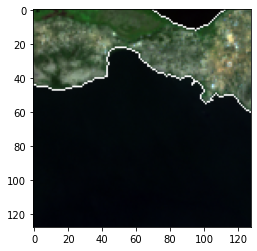

In [19]:
plt.imshow(X[0]+Y[0,...,np.newaxis])

In [20]:
ix = shuffle(np.arange(9108),random_state=0)

In [21]:
((ix[:1000] < 4053)*1).sum()

425

In [22]:
4053/9108

0.44499341238471674

# Pytorch DataLoaders

In [23]:
class NDWIDataset(Dataset):

    def __init__(self, images, masks, transform=None, test_transform=None):
        self.images     = images
        self.masks      = masks
        self.transforms = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
        
        image = augmentations['image']
        mask  = augmentations['mask']
        mask  = mask[np.newaxis,:,:]
        
        return [image.type(torch.float32), 
                mask.type(torch.float32)]
        

In [24]:
def data(trans, trans_test, X_train, Y_train, X_val, Y_val, X_test, Y_test, split=0.9, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset= NDWIDataset(X_train, Y_train, transform=trans)

    if val:
        print(f'Training:{len(X_train)}, Validation:{len(X_val)}')
        print(f'Testing: {len(X_test)}')
        
        valset  = NDWIDataset(X_val, Y_val, transform=trans_test)
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        print(f'Training:{len(X_train)}')
        print(f'Testing: {len(X_test)}')
        testset = NDWIDataset(X_test, Y_test, transform=trans_test)
        image_datasets = {'train': trainset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [25]:
def data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9, factor=1, val=True, batch_size=16):
    torch.manual_seed(49)
    random.seed(49)
    trainset = NDWIDataset_from_dir_reg(list_train, transform=trans)

    if val:
#         lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+factor]
        
        valset  = NDWIDataset_from_dir_reg(list_val, transform=trans)
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        print(f'Training:{len(list_train)}, Validation:{len(list_val)}')
        print(f'Testing: {len(list_test)}')
        image_datasets = {'train': trainset, 'val': valset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'val': DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    else:
        lengths = [int(len(dataset))]
        print(f'Training:{len(list_train)}')
        print(f'Testing: {len(list_test)}')
        testset = NDWIDataset_from_dir_reg(list_test, transform=trans_test)
        image_datasets = {'train': dataset, 'test': testset}
        batch_size = batch_size

        dataloaders = {
          'train': DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True),#, num_workers=8),
          'test': DataLoader(testset, batch_size=batch_size, shuffle=False, pin_memory = True)#, num_workers=8)
        }
        
    
    return dataloaders

In [26]:
def data_pseudo(trans, img_paths, model, batch_size=32, split=None):
    torch.manual_seed(49)
    random.seed(49)
    if split==None:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset))]
        print(f'Pseudo-Training:{lengths[0]}')
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory = True)#, num_workers=8)
    else:
        dataset = NDWIDataset_from_dir(img_paths, model, transform=trans)
        lengths = [int(len(dataset)*split), int(len(dataset)*(1-split))+1]
        trainset, valset = torch.utils.data.random_split(dataset, lengths)
        
        print(f'Pseudo-Training, Train: {len(trainset)}, Validation: {len(valset)}')
        dataloader = {'train':DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory = True),
                      'val'  :DataLoader(valset, batch_size=batch_size, shuffle=True, pin_memory = True)}

    
    return dataloader

In [27]:
trans = A.Compose([
#     A.RandomCrop(128,128),
#     A.VerticalFlip(),
#     A.HorizontalFlip(),
    ToTensorV2()])
trans_test = A.Compose([
#              A.RandomCrop(128,128),
             ToTensorV2()])

In [28]:
def plot_rand(dataloader, set_='train'):
    if set_==None:
        for x,y in dataloader:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    else:
        for x,y in dataloader[set_]:
            x,y = x.numpy().transpose([0,2,3,1]), y.numpy().squeeze()
            break
    rand = np.random.randint(0,x.shape[0])
    plt.subplot(121)
    plt.imshow(x[rand])
    plt.title('Image')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(y[rand])
    plt.title('Contour')
    plt.axis('off')
    plt.show()
#     return x,y

In [29]:
# dataloaders  = data_from_dir_reg(trans, trans_test, list_train, list_val, list_test, split=0.9)
# # dataloader_p = data_pseudo(trans, list_paths, model_pred)

# Evaluation Metrics

In [30]:
def f1_score(y_pred, y_true, threshold=0.5):
    
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    y_pred = ((y_pred>threshold)*1.).type(torch.float32)
    
    tp = torch.sum(y_true*(y_pred))
    tn = torch.sum((1-y_true)*((1-y_pred)))
    fp = torch.sum((1-y_true)*(y_pred))
    fn = torch.sum((y_true)*((1-y_pred)))
    
    pr  = ((tp+1.)/(tp+fp+1.))
    rec = ((tp+1.)/(tp+fn+1.))
    f1  = ((2*pr*rec)/(pr+rec))
    return f1

 Exponential MA = $V_{t} = \beta V_{t-1} + (1-\beta)(current)$

In [31]:
# def test_pred(model,X_test,batch_size=32):
#     model.eval()
#     print(model.training)
#     if model.training==True:
#         raise ValueError('Model is in training mode')
#     else:
#         pass
#     dataloader = dataloaders['test']
#     for x,y in dataloaders['test']:
#         X, Y = x, y
#         break

#     predictions = np.zeros([len(X_test),Y.shape[1],Y.shape[2],Y.shape[3]])
#     test_images = np.zeros([len(X_test),X.shape[1],X.shape[2],X.shape[3]])
#     test_masks = np.zeros([len(X_test),Y.shape[1],Y.shape[2],Y.shape[3]])
    
#     i = 0
#     for x, y in tqdm(dataloaders['test']):
#         test_images[i:i+batch_size] = x
#         test_masks[i:i+batch_size] = y
#         torch.cuda.empty_cache()
#         predictions[i:i+batch_size] = model(x.cuda()).cpu().detach().numpy()
#         i+=batch_size
#     return test_images, test_masks, predictions




























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































































# Experiments

In [32]:
# model_dir = r"C:\Users\Engineering HPC Lab\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\self_train\1"
# csv_dir   = r"C:\Users\Engineering HPC Lab\OneDrive - University of New Orleans\Documents\Research\Year 1\Paper Experiments\Results\self_train\1\F-scores-self_learning.csv"

In [33]:
# def test_pred(model,X_test,batch_size=32):
#     model.eval()
#     if model.training==True:
#         raise ValueError('Model is in training mode')
#     else:
#         pass
    
#     predictions = np.zeros([len(X_test),1,X_test.shape[1],X_test.shape[2]])
#     i = 0
#     for x, y in tqdm(dataloaders['test']):
#         predictions[i:i+batch_size] = model(x.cuda()).cpu().detach().numpy()
#         i+=batch_size
#     return predictions

In [34]:
class basic_block(nn.Module):
#    def __init__(self,in_channels,out_channels, random_state=0):
    def __init__(self,in_channels,out_chan, random_state=0):
        super(basic_block,self).__init__()
        
        #out_channels = out_chan
        out_channels = out_chan//2
        
        torch.manual_seed(random_state)
        self.bn1         = nn.BatchNorm2d(in_channels)
        
        self.conv1x1_1_1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn2         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_3 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn3         = nn.BatchNorm2d(out_channels)
        
        self.conv3x3_1   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn4         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_5 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn5         = nn.BatchNorm2d(out_channels)
        
        self.conv5x5_1   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn6         = nn.BatchNorm2d(out_channels)
        
        self.conv1x1_1_7 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn7         = nn.BatchNorm2d(out_channels)
        
        self.conv7x7_1   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn8         = nn.BatchNorm2d(out_channels)
        
        self.bn9         = nn.BatchNorm2d(out_channels*4)
        self.conv1x1_2_1 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn10        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_3 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn11        = nn.BatchNorm2d(out_channels)
        self.conv3x3_2   = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn12        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_5 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn13        = nn.BatchNorm2d(out_channels)
        self.conv5x5_2   = nn.Conv2d(out_channels,out_channels,5,padding=2)
        self.bn14        = nn.BatchNorm2d(out_channels)
        self.conv1x1_2_7 = nn.Conv2d(out_channels*4, out_channels, 1)
        self.bn15        = nn.BatchNorm2d(out_channels)
        self.conv7x7_2   = nn.Conv2d(out_channels,out_channels,7,padding=3)
        self.bn16        = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        
        bn1         = self.bn1(x)
        conv1x1_1_3 = self.bn3(self.conv1x1_1_3(bn1))
        conv1x1_1_5 = self.bn4(self.conv1x1_1_5(bn1))
        conv1x1_1_7 = self.bn5(self.conv1x1_1_7(bn1))
        conv1x1_1_1 = F.relu(self.bn2(self.conv1x1_1_1(bn1)))
        conv3x3_1   = F.relu(self.bn6(self.conv3x3_1(conv1x1_1_3)))
        conv5x5_1   = F.relu(self.bn7(self.conv5x5_1(conv1x1_1_5)))
        conv7x7_1   = F.relu(self.bn8(self.conv7x7_1(conv1x1_1_7)))
        cat1        = torch.cat([conv1x1_1_1,conv3x3_1,conv5x5_1,conv7x7_1],dim=1)
        
        bn9         = self.bn9(cat1)
        conv1x1_2_3 = self.bn11(self.conv1x1_2_3(bn9))
        conv1x1_2_5 = self.bn12(self.conv1x1_2_5(bn9))
        conv1x1_2_7 = self.bn13(self.conv1x1_2_7(bn9))
        conv1x1_2_1 = F.relu(self.bn10(self.conv1x1_2_1(bn9)))
        conv3x3_2   = F.relu(self.bn14(self.conv3x3_2(conv1x1_2_3)))
        conv5x5_2   = F.relu(self.bn15(self.conv5x5_2(conv1x1_2_5)))
        conv7x7_2   = F.relu(self.bn16(self.conv7x7_2(conv1x1_2_7)))
        cat2        = torch.cat([conv1x1_2_1,conv3x3_2,conv5x5_2,conv7x7_2],dim=1)

  
        return cat2
        

class UNET_multiscale2(nn.Module):
###    def __init__(self, in_channels=3, out_channels= 1, init_features=16, random_state=0):
    def __init__(self, in_channels=3, out_channels= 1, init_features=32, random_state=0):
        super(UNET_multiscale2, self).__init__()
        torch.manual_seed(random_state)
        features = init_features
        self.layer1 =  basic_block(3,features)
        self.down1  = nn.Conv2d(features*2,features,2,stride=2)
        
        self.layer2 = basic_block(features,features) 
        self.down2  = nn.Conv2d(features*2,features*2,2,stride=2)

        self.layer3 = basic_block(features*2,features*2) 
        self.down3  = nn.Conv2d(features*4,features*4,2,stride=2)

        self.layer4 = basic_block(features*4,features*4)
        self.down4  = nn.Conv2d(features*8,features*8,2,stride=2)
        
        self.bottleneck = basic_block(features*8,features*8)
        self.bn6     = nn.BatchNorm2d(features*8*2)
        self.up1     = nn.ConvTranspose2d(features*16, features*8, 2, stride=2)
               
        self.layer6  = basic_block(features*16,features*4)      
        self.bn7     = nn.BatchNorm2d(features*4*2)
        self.up2     = nn.ConvTranspose2d(features*8, features*4, 2, stride=2)

        self.layer7  = basic_block(features*8,features*2) 
        self.bn8     = nn.BatchNorm2d(features*2*2)
        self.up3     = nn.ConvTranspose2d(features*4, features*2, 2, stride=2)   
        
        self.layer8  = basic_block(features*4,features) 
        self.bn9     = nn.BatchNorm2d(features*2)
        self.up4     = nn.ConvTranspose2d(features*2, features*2, 2, stride=2)
        
        self.layer9  = basic_block(features*4,features)
        self.out     = nn.Conv2d(features*2, 1, 3, padding=1)
        
    def forward(self, x):
        
        layer1 = self.layer1(x)
        down1  = F.relu(self.down1(layer1))

        layer2 = self.layer2(down1) 
        down2  = F.relu(self.down2(layer2))
        
        layer3 = self.layer3(down2) 
        down3  = F.relu(self.down3(layer3))
        
        layer4 = self.layer4(down3) 
        down4  = F.relu(self.down4(layer4))

        
        bottleneck = self.bottleneck(down4)
        up1     = F.relu(self.up1(self.bn6(bottleneck), output_size=layer4.size()))

        merge1  = torch.cat([up1, layer4], dim=1)      
        layer6  = self.layer6(merge1)
        up2        = F.relu(self.up2(self.bn7(layer6), output_size=layer3.size()))

        merge2     = torch.cat([up2, layer3], dim=1)
        layer7     = self.layer7(merge2)
        up3        = F.relu(self.up3(self.bn8(layer7), output_size=layer2.size()))

        merge3     = torch.cat([up3, layer2], dim=1)
        layer8  = self.layer8(merge3)
        up4        = F.relu(self.up4(self.bn9(layer8), output_size=layer1.size()))
        
        merge4     = torch.cat([up4, layer1], dim=1)
        layer9  = self.layer9(merge4)                    
        out        = torch.sigmoid(self.out(layer9))
                        
        return out



In [35]:
import time
def train_round1(model, dataloaders, augmented, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    counter=0
    train_loss, valid_loss = [], []                            #Running training and validation loss
    val_epoch, f1_epoch = [0],[0]
    loss_list = []
    times     = []
    AP_epoch=[]
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        print(scheduler.get_last_lr())
    

    #########################################Begin Model Training######################################################
    ###################################################################################################################
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()                             # Set training mode all the layers including batchnorm and dropout work in this
                dataloader = dataloaders['train']         #get the training data
                dataloader2 = augmented['train']         #get the training data
            else:
                model.eval()                              # Set model to evaluate mode deactivates the batchnorm and dropout layers
                dataloader = dataloaders['val']           #get the validation data

            running_loss = 0.0                            #running loss to be used for visualization later
            step = 0                                      #Batch number
            
            if phase == 'train':  
                f1 = []
                AP = []
                for inputs, labels in dataloader:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 
                    ######################################################################
                for inputs, labels in dataloader2:
                    x, y = inputs.to(device), labels.to(device)
                    step += 1

                    optimizer.zero_grad()                                   # zero the gradients
                    outputs = model(x)                                      #get model output for a given input

                    #################Metrics###################
                    f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                    AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                    ##################Calculate Loss, backprop, and update###############
                    loss           = loss_fn(outputs, y)
                    train_loss.append(loss.cpu().detach().numpy())
                    loss.backward()
                    optimizer.step()
                    print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f}, Loss: {loss:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', end='\r') 
                    ######################################################################
        
            else:  
                loss_val = []
                f1=[]
                AP = []
                with torch.no_grad():
                    for inputs, labels in dataloader:
                        x, y = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()                                   # zero the gradients
                        outputs = model(x)                                      #get model output for a given input

                        #################Metrics###################
                        f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                        AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))

                    ############################################

                        ##################Calculate Loss, backprop, and update###############
                        valid_loss.append(loss_fn(outputs, y).cpu().detach().numpy())
                        loss_val.append(valid_loss[-1])
                val_epoch.append(np.mean(loss_val))
                f1_epoch.append(np.mean(f1))
                AP_epoch.append(np.mean(AP))
                print()
                print()
                print(f' Loss val: {val_epoch[-1]:.3f}, F-Score val:{f1_epoch[-1]:.3f}, AP val:{AP_epoch[-1]:.3f} \n') 
                ######################################################################
                

            print()
            time_elapsed = time.time() - start_epoch
            times.append(time_elapsed)
            print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
            print('-' * 10)      

        scheduler.step()
        torch.save(model, save_last+ '\\' + f'Epoch_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {'Train Loss':train_loss,
            'Valid Loss':valid_loss,
            'Times'     :times,
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

## Round1(Train Using Labeled Data Only)

In [36]:
X_train_labeled = X#[:1]
Y_train_labeled = Y#[:1]

print(X_train_labeled.shape)

(4500, 128, 128, 3)


In [37]:
trans = A.Compose([
#    A.VerticalFlip(),
#    A.HorizontalFlip(),    
    ToTensorV2()])
trans_test = A.Compose([
                ToTensorV2()])

batch_size = 32
dataloaders = data(trans, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [38]:
trans2 = A.Compose([
   A.VerticalFlip( p=1),
   A.HorizontalFlip( p=1),   
#     A.RandomCrop(height=128, width=128,p=1),
#     A.CenterCrop(height=96, width=96),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),
#     A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
#     A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()])
#trans_test = A.Compose([
                #ToTensorV2()])


batch_size = 32

dataloadersAugmented = data(trans2, trans_test, X_train_labeled, Y_train_labeled, X_val, Y_val, X_test, Y_test, batch_size=batch_size)

Training:4500, Validation:500
Testing: 2000


In [39]:
d1= dataloaders['train']

In [11]:
import math
math.ceil(4500/16)


282

In [8]:
math.ceil(4608/16)

288

In [15]:
(4608+4500)/32

569.25

In [14]:
math.ceil((4608+4500)/16)

570

In [40]:
x1,y1 = next(iter(d1 ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


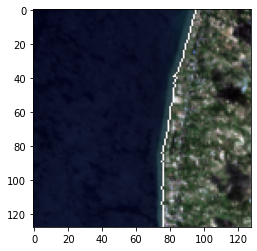

In [41]:

for i in range(1):
    plt.imshow(x1[i].permute(1,2,0)+y1[i].permute(1,2,0))#plt.imshow(x1[0]+y1[0,...,np.newaxis])
    plt.figure(i+1)

plt.show()

In [42]:
d2 = dataloadersAugmented['train']  

In [43]:
x2,y2 = next(iter(d2 ))

In [44]:
i=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


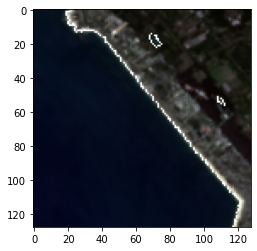

In [45]:
for i in range(1):
    plt.imshow(x2[i].permute(1,2,0)+y2[i].permute(1,2,0))#plt.imshow(x1[0]+y1[0,...,np.newaxis])
    plt.figure(i+1)

plt.show()

In [46]:
y1.shape

torch.Size([32, 1, 128, 128])

In [47]:


model = UNET_multiscale2().to(device)
opt = optim.Adam(model.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[100,180], gamma=0.1)

summary(model,(3,128,128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 128, 128]               6
            Conv2d-2         [-1, 16, 128, 128]              64
       BatchNorm2d-3         [-1, 16, 128, 128]              32
            Conv2d-4         [-1, 16, 128, 128]              64
       BatchNorm2d-5         [-1, 16, 128, 128]              32
            Conv2d-6         [-1, 16, 128, 128]              64
       BatchNorm2d-7         [-1, 16, 128, 128]              32
            Conv2d-8         [-1, 16, 128, 128]              64
       BatchNorm2d-9         [-1, 16, 128, 128]              32
           Conv2d-10         [-1, 16, 128, 128]           2,320
      BatchNorm2d-11         [-1, 16, 128, 128]              32
           Conv2d-12         [-1, 16, 128, 128]           6,416
      BatchNorm2d-13         [-1, 16, 128, 128]              32
           Conv2d-14         [-1, 16, 1

In [48]:
history = train_round1(model, dataloaders, dataloadersAugmented, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score, epochs=50)

Epoch 0
[0.003]
Current step: 282, AllocMem (Mb): 111.149, Loss: 1.261,  F1: 0.444,  AP: 0.394
Training complete in 1m 56s
----------


 Loss val: 1.105, F-Score val:0.527, AP val:0.520 


Training complete in 1m 59s
----------
Epoch 1
[0.003]
Current step: 282, AllocMem (Mb): 111.149, Loss: 1.195,  F1: 0.525,  AP: 0.500
Training complete in 1m 55s
----------


 Loss val: 1.041, F-Score val:0.546, AP val:0.564 


Training complete in 1m 58s
----------
Epoch 2
[0.003]
Current step: 282, AllocMem (Mb): 111.149, Loss: 1.065,  F1: 0.555,  AP: 0.539
Training complete in 1m 56s
----------


 Loss val: 0.993, F-Score val:0.581, AP val:0.604 


Training complete in 1m 59s
----------
Epoch 3
[0.003]
Current step: 282, AllocMem (Mb): 111.149, Loss: 1.141,  F1: 0.573,  AP: 0.563
Training complete in 1m 56s
----------


 Loss val: 0.981, F-Score val:0.603, AP val:0.612 


Training complete in 1m 59s
----------
Epoch 4
[0.003]
Current step: 282, AllocMem (Mb): 111.149, Loss: 1.094,  F1: 0.591,  AP:

In [49]:
df = pd.DataFrame(history['f1_epoch'])
                  
df.to_csv(save_last+ '\\'+ "UNET_MC_2_LandSAT_Augmentation.csv")

In [50]:
# with open(r'{}historyFeature32_trainLoss.txt'.format(save_last), 'w') as f:
#     print(history['Valid Loss'], file=f)

In [51]:
def test(model, dataloaders, loss_fn, optimizer, acc_fn, random_state=49, epochs=1):
    
    
    torch.manual_seed(random_state)
    np.random.seed(random_state)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    start = time.time()                                        #Initialize time to calculate time it takes to train model
    model.to(device)                                               #Move model to GPU     

    model.eval()
    
    counter=0
    #train_loss,
    test_loss = []                         #Running training and validation loss
    loss_epoch, f1_epoch = [0],[0]
    AP_epoch =[0]
    loss_list = []
    times     = []
    
    for epoch in range(epochs):
        start_epoch = time.time()
        print(f'Epoch {epoch}')
        print(scheduler.get_last_lr())
    

 ################ MODEL TESTING  #############################

        dataloader = dataloaders['test']         #get the training data

        step = 0
        loss_test = []
        f1=[]
        AP = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                x, y = inputs.to(device), labels.to(device)
                optimizer.zero_grad()                                   # zero the gradients
                outputs = model(x)                                      #get model output for a given input

                #################Metrics###################
                f1.append(acc_fn(outputs, y).cpu().detach().numpy())
                AP.append(average_precision_score(y.reshape(-1).cpu().detach().numpy(),  outputs.reshape(-1).cpu().detach().numpy()))
                loss_test.append(loss_fn(outputs, y).cpu().detach().numpy())
            ############################################
                print(f'Current step: {step}, AllocMem (Mb): {torch.cuda.memory_allocated()/1024/1024:.3f},  F1: {np.mean(f1):.3f},  AP: {np.mean(AP):.3f}', "\n") 

                step+=1
                ##################Calculate Loss, backprop, and update###############
               
                test_loss.append(loss_test[-1])
        loss_epoch.append(np.mean(loss_test))
        f1_epoch.append(np.mean(f1))
        AP_epoch.append(np.mean(AP))
        print()
        print()
        print(f' Loss test: {loss_epoch[-1]:.3f}, F-Score test:{f1_epoch[-1]:.3f}, AP val:{AP[-1]:.3f} \n') 
        ######################################################################
                

            

        scheduler.step()
#         torch.save(model, save_last+ '\\' + f'Epcoh_{str(epoch).zfill(3)}'+ '.pth')
        epoch+=1
    #########################################End Model Training######################################################
    ###################################################################################################################
    
    #Total training time including time to test
    time_elapsed = time.time() - start
    print('\n Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
#     torch.save(model, save_last+ '\\' + f'Feature32_{str(1000)}_images'+ '.pth')
    
    return {
            'f1_epoch':f1_epoch,
            'Epochs': epoch}

In [52]:
testmodel = torch.load(save_last + "\\" + "Epoch_045.pth")

In [53]:
test_history = test(testmodel, dataloaders, loss_fn = border_loss, optimizer = opt, acc_fn = f1_score)

Epoch 0
[0.003]
Current step: 0, AllocMem (Mb): 139.187,  F1: 0.689,  AP: 0.736 

Current step: 1, AllocMem (Mb): 139.187,  F1: 0.677,  AP: 0.719 

Current step: 2, AllocMem (Mb): 139.187,  F1: 0.679,  AP: 0.724 

Current step: 3, AllocMem (Mb): 139.187,  F1: 0.656,  AP: 0.691 

Current step: 4, AllocMem (Mb): 139.187,  F1: 0.666,  AP: 0.705 

Current step: 5, AllocMem (Mb): 139.187,  F1: 0.674,  AP: 0.714 

Current step: 6, AllocMem (Mb): 139.187,  F1: 0.675,  AP: 0.716 

Current step: 7, AllocMem (Mb): 139.187,  F1: 0.673,  AP: 0.717 

Current step: 8, AllocMem (Mb): 139.187,  F1: 0.667,  AP: 0.709 

Current step: 9, AllocMem (Mb): 139.187,  F1: 0.666,  AP: 0.705 

Current step: 10, AllocMem (Mb): 139.187,  F1: 0.664,  AP: 0.700 

Current step: 11, AllocMem (Mb): 139.187,  F1: 0.664,  AP: 0.699 

Current step: 12, AllocMem (Mb): 139.187,  F1: 0.666,  AP: 0.700 

Current step: 13, AllocMem (Mb): 139.187,  F1: 0.665,  AP: 0.695 

Current step: 14, AllocMem (Mb): 139.187,  F1: 0.666,  A

In [54]:
df = pd.DataFrame(history['f1_epoch'])
                  
df.to_csv(save_last+ '\\'+ "UNET_MC_2_LandSAT_test.csv")

In [55]:
highest = 0.7
mean = 0.695

In [56]:
#     return {'Train Loss':train_loss,
#             'Valid Loss':valid_loss,
#             'Times'     :times,
#             'Epochs': epoch}